In [1]:
from fpgrowth_py import fpgrowth # Importation de la bibliothèque fpgrowth pour l'algorithme FP-Growth
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns
import time

In [2]:
# Chargement des données depuis le fichier CSV avec l'encodage approprié
data = pd.read_csv('ecommerce-data/data.csv', encoding='ISO-8859-1')

# Calcul de la colonne 'GroupPrice'
data['GroupPrice'] = data['Quantity'] * data['UnitPrice']

# Affichage des dimensions du jeu de données
print('Dimensions du jeu de données : ', data.shape)

Dimensions du jeu de données :  (541909, 9)


In [3]:
# Suppression des lignes contenant des valeurs manquantes
data = data.dropna()

# Affichage des nouvelles dimensions après la suppression des valeurs manquantes
print('Les nouvelles dimensions après la suppression des valeurs manquantes :', data.shape)
print('---------')
print(data.head())

Les nouvelles dimensions après la suppression des valeurs manquantes : (406829, 9)
---------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  GroupPrice  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom       15.30  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom       20.34  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom       22.00  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom       20.34  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom       20.34  


In [4]:
# Liste des codes de stock uniques
liste = data['StockCode'].unique() 

# Création d'une liste de codes de stock à supprimer
stock_to_del = []
for el in liste:
    # Supprimer les produits correspondant à des cadeaux (codes de stock qui ne commencent pas par un chiffre)
    if el[0] not in ['1','2','3','4','5','6','7','8','9','10']:
        stock_to_del.append(el)

# Suppression des produits indésirables du jeu de données
data = data[data['StockCode'].map(lambda x: x not in stock_to_del)]

# Grouper les produits par facture et client
basket = data.groupby(['InvoiceNo', 'CustomerID']).agg({'StockCode': lambda s: list(set(s))})

# Affichage des dimensions du nouveau jeu de données regroupé
print('Dimension du nouveau jeu de données regroupé :', basket.shape)
print('----------')
print(basket.head())

Dimension du nouveau jeu de données regroupé : (21788, 1)
----------
                                                              StockCode
InvoiceNo CustomerID                                                   
536365    17850.0     [85123A, 84029G, 84029E, 84406B, 71053, 21730,...
536366    17850.0                                        [22632, 22633]
536367    13047.0     [48187, 21777, 22749, 22748, 22622, 22623, 217...
536368    13047.0                          [22913, 22912, 22914, 22960]
536369    13047.0                                               [21756]


In [5]:
# Mesure du temps d'exécution
a = time.time()

# Application de l'algorithme FP-Growth pour extraire les fréquent items sets et les règles d'association
freqItemSet, rules = fpgrowth(basket['StockCode'].values, minSupRatio=0.005, minConf=0.5)

# Mesure du temps d'exécution
b = time.time()

# Affichage du temps d'exécution en secondes
print("Temps d'exécution en secondes : ", b - a, 's.')

# Affichage du nombre de règles générées
print('Nombre de règles générées : ', len(rules))

# Création d'un DataFrame à partir des règles d'association
association = pd.DataFrame(rules, columns=['basket', 'next_product', 'proba'])

# Tri du DataFrame en fonction de la probabilité (confidence) de manière décroissante
association = association.sort_values(by='proba', ascending=False)

# Affichage des dimensions du tableau d'association
print("Les dimensions du tableau d'association : ", association.shape)

# Affichage des 10 premières lignes du tableau d'association
print(association.head(10))

Temps d'exécution en secondes :  304.5836362838745 s.
Nombre de règles générées :  2723
Les dimensions du tableau d'association :  (2723, 3)
                                  basket next_product     proba
190  {22921, 22919, 22920, 22917, 22916}      {22918}  0.992537
412         {22921, 22916, 22917, 22919}      {22918}  0.986014
296         {22921, 22920, 22918, 22917}      {22916}  0.985714
298         {22921, 22920, 22916, 22917}      {22918}  0.985714
219         {22921, 22920, 22916, 22919}      {22918}  0.985401
83          {22921, 22920, 22917, 22919}      {22918}  0.985401
188  {22921, 22919, 22920, 22918, 22916}      {22917}  0.985185
187  {22921, 22919, 22920, 22918, 22917}      {22916}  0.985185
355                {22921, 22917, 22916}      {22918}  0.979866
447                {22921, 22919, 22917}      {22918}  0.979730


In [6]:
def compute_next_best_product(basket_el):
    """
    paramètre : basket_el = liste des éléments du panier du consommateur
    retour : next_pdt, proba = prochain produit à recommander, probabilité d'achat. Ou (0,0) si aucun produit n'est trouvé.
    
    Description : à partir du panier d'un utilisateur, renvoie le produit à recommander s'il n'est pas trouvé 
    dans la liste des associations de la table associée au modèle FP-Growth. 
    Pour ce faire, nous recherchons dans la table des associations le produit à recommander à partir de chaque 
    produit individuel dans le panier du consommateur.
    """
    
    for k in basket_el:  # Pour chaque élément dans le panier du consommateur
        k = {k}
        if len(association[association['basket'] == k].values) != 0:  # Si nous trouvons une association correspondante dans la table FP Growth
            next_pdt = list(association[association['basket'] == k]['next_product'].values[0])[0]  # Nous prenons le produit conséquent
            if next_pdt not in basket_el:  # Nous vérifions si le client n'a pas déjà acheté le produit
                proba = association[association['basket'] == k]['proba'].values[0]  # Trouver la probabilité associée
                return next_pdt, proba
    
    return 0, 0  # Retourne (0,0) si aucun produit n'a été trouvé.


In [7]:
def find_next_product(basket):
    """
    Paramètre : basket = dataframe du panier du consommateur
    Retour : list_next_pdt, list_proba = liste des prochains éléments à recommander et les probabilités d'achat associées.
    
    Description : Fonction principale qui utilise la fonction ci-dessus. Pour chaque client dans le jeu de données, 
    nous recherchons une association correspondante dans la table du modèle FP Growth. Si aucune association n'est trouvée, 
    nous appelons la fonction compute_next_best_product qui recherche des associations de produits individuels.
    Si aucune association individuelle n'est trouvée, la fonction retourne (0,0).
    """
    n = basket.shape[0]
    list_next_pdt = []
    list_proba = []
    for i in range(n):  # Pour chaque client
        el = set(basket['StockCode'][i])  # Panier du client
        if len(association[association['basket'] == el].values) != 0:  # Si nous trouvons une association correspondante dans la table FP Growth
            next_pdt = list(association[association['basket'] == el]['next_product'].values[0])[0]  # Nous prenons le produit conséquent
            proba = association[association['basket'] == el]['proba'].values[0]  # Probabilité associée dans la table
            list_next_pdt.append(next_pdt)
            list_proba.append(proba)

        elif len(association[association['basket'] == el].values) == 0:  # Si aucun antécédent correspondant à tout le panier n'est trouvé dans la table
            next_pdt, proba = compute_next_best_product(basket['StockCode'][i])  # Appel à la fonction précédente
            list_next_pdt.append(next_pdt)
            list_proba.append(proba)

    return list_next_pdt, list_proba


In [8]:
a = time.time()

# Appel de la fonction find_next_product pour obtenir les produits recommandés et les probabilités associées
list_next_pdt, list_proba = find_next_product(basket)

b = time.time()
print("Temps d'exécution de la fonction", b - a)  # Affichage du temps d'exécution de la fonction

# Ajout des colonnes 'Recommended Product' et 'Probability' au DataFrame basket
basket['Recommended Product'] = list_next_pdt  # Ensemble des produits recommandés
basket['Probability'] = list_proba  # Ensemble des probabilités associées

# Affichage des premières lignes du DataFrame mis à jour
basket.head()


Temps d'exécution de la fonction 165.5179386138916


,,StockCode,Recommended Product,Probability
InvoiceNo,CustomerID,,,
536365,17850.0,"[85123A, 84029G, 84029E, 84406B, 71053, 21730,...",0,0.000000
536366,17850.0,"[22632, 22633]",22865,0.516393
536367,13047.0,"[48187, 21777, 22749, 22748, 22622, 22623, 217...",22750,0.593516
536368,13047.0,"[22913, 22912, 22914, 22960]",0,0.000000
536369,13047.0,[21756],21754,0.576132


In [9]:
# Renommer la colonne 'StockCode' en 'Customer basket' dans le DataFrame basket
basket = basket.rename(columns={'StockCode': 'Customer basket'})

# Créer un DataFrame data_stock contenant les données uniques basées sur 'StockCode' dans le DataFrame data
data_stock = data.drop_duplicates(subset="StockCode", inplace=False)

# Initialiser des listes vides pour stocker les informations sur les prix et les descriptions
prices = []
description_list = []

# Parcourir chaque ligne du DataFrame basket
for i in range(basket.shape[0]):
    stockcode = basket['Recommended Product'][i]
    probability = basket['Probability'][i]
    
    # Si le code de stock n'est pas 0 (c'est-à-dire, s'il y a un produit recommandé)
    if stockcode != 0:
        # Obtenir le prix unitaire et la description du produit recommandé
        unitprice = data_stock[data_stock['StockCode'] == stockcode]['UnitPrice'].values[0]
        description = data_stock[data_stock['StockCode'] == stockcode]['Description'].values[0]
        
        # Estimer le prix en multipliant le prix unitaire par la probabilité
        estim_price = unitprice * probability
        
        # Ajouter le prix estimé et la description à leurs listes respectives
        prices.append(estim_price)
        description_list.append(description)
    else:
        # Si le code de stock est 0, ajouter 0 au prix et 'Null' à la description
        prices.append(0)
        description_list.append('Null')

# Ajouter les listes de prix et de descriptions au DataFrame basket
basket['Price estimation'] = prices
basket['Product description'] = description_list

# Réorganiser les colonnes du DataFrame basket
basket = basket.reindex(columns=['Customer basket', 'Recommended Product', 'Product description', 'Probability', 'Price estimation'])

# Afficher les premières lignes du DataFrame basket mis à jour
print(basket.head())

                                                        Customer basket  \
InvoiceNo CustomerID                                                      
536365    17850.0     [85123A, 84029G, 84029E, 84406B, 71053, 21730,...   
536366    17850.0                                        [22632, 22633]   
536367    13047.0     [48187, 21777, 22749, 22748, 22622, 22623, 217...   
536368    13047.0                          [22913, 22912, 22914, 22960]   
536369    13047.0                                               [21756]   

                     Recommended Product           Product description  \
InvoiceNo CustomerID                                                     
536365    17850.0                      0                          Null   
536366    17850.0                  22865        HAND WARMER OWL DESIGN   
536367    13047.0                  22750  FELTCRAFT PRINCESS LOLA DOLL   
536368    13047.0                      0                          Null   
536369    13047.0             

In [10]:
print('En moyenne, le système de recommandation peut prédire en ', basket['Probability'].mean() * 100, '% des cas le prochain produit que le client achètera.')

En moyenne, le système de recommandation peut prédire en  31.89600030808497 % des cas le prochain produit que le client achètera.


In [11]:
# Affichage des 10 premières règles d'association
print("Top 10 premières règles d'association:")
print(association.head(10))

Top 10 premières règles d'association:
                                  basket next_product     proba
190  {22921, 22919, 22920, 22917, 22916}      {22918}  0.992537
412         {22921, 22916, 22917, 22919}      {22918}  0.986014
296         {22921, 22920, 22918, 22917}      {22916}  0.985714
298         {22921, 22920, 22916, 22917}      {22918}  0.985714
219         {22921, 22920, 22916, 22919}      {22918}  0.985401
83          {22921, 22920, 22917, 22919}      {22918}  0.985401
188  {22921, 22919, 22920, 22918, 22916}      {22917}  0.985185
187  {22921, 22919, 22920, 22918, 22917}      {22916}  0.985185
355                {22921, 22917, 22916}      {22918}  0.979866
447                {22921, 22919, 22917}      {22918}  0.979730


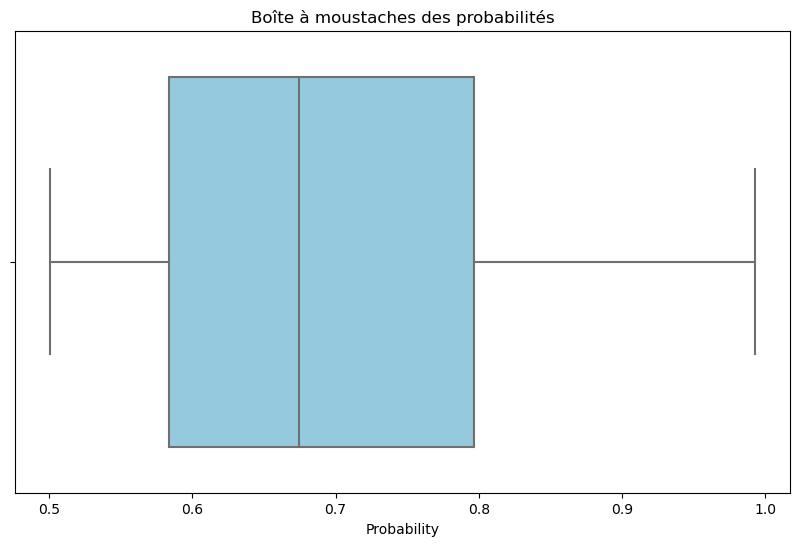

In [12]:
# Boîte à moustaches des probabilités
plt.figure(figsize=(10, 6))
sns.boxplot(x=association['proba'], color='skyblue')
plt.title('Boîte à moustaches des probabilités')
plt.xlabel('Probability')
plt.show()

In [13]:
# Statistiques descriptives des probabilités
print('Statistiques descriptives des probabilités:')
print(association['proba'].describe())

Statistiques descriptives des probabilités:
count    2723.000000
mean        0.696068
std         0.131752
min         0.500741
25%         0.583674
50%         0.674419
75%         0.796394
max         0.992537
Name: proba, dtype: float64


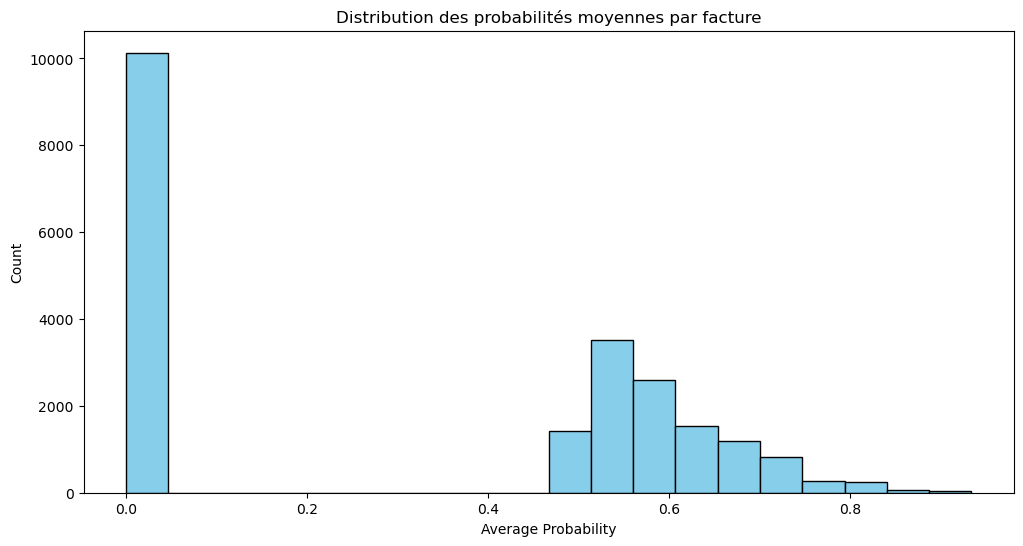

In [14]:
# Calcul de la moyenne des probabilités par facture
average_probabilities = basket.groupby(['InvoiceNo', 'CustomerID'])['Probability'].mean()

# Histogramme des moyennes de probabilités par facture
plt.figure(figsize=(12, 6))
plt.hist(average_probabilities, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution des probabilités moyennes par facture')
plt.xlabel('Average Probability')
plt.ylabel('Count')
plt.show()

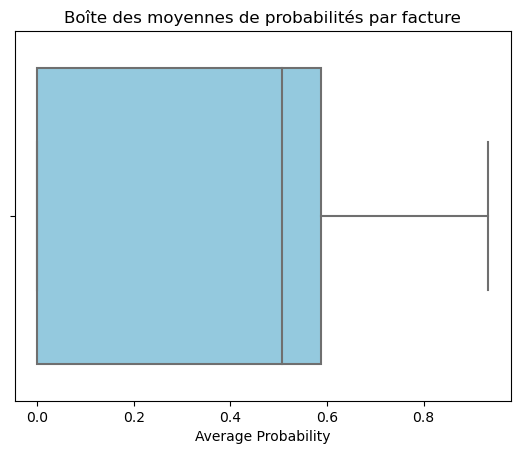

In [15]:
# Graphique en boîte des moyennes de probabilités par facture

sns.boxplot(x=average_probabilities, color='skyblue')
plt.title('Boîte des moyennes de probabilités par facture')
plt.xlabel('Average Probability')
plt.show()

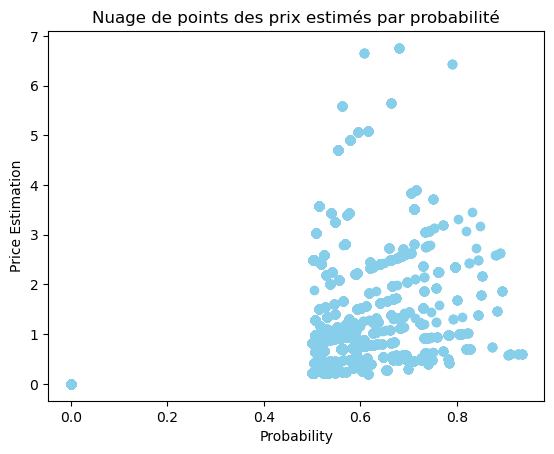

In [16]:
# Nuage de points des prix estimés par probabilité
plt.scatter(basket['Probability'], basket['Price estimation'], color='skyblue')
plt.title('Nuage de points des prix estimés par probabilité')
plt.xlabel('Probability')
plt.ylabel('Price Estimation')
plt.show()

In [17]:
# Statistiques descriptives des prix estimés
print('Statistiques descriptives des prix estimés:')
print(basket['Price estimation'].describe())

Statistiques descriptives des prix estimés:
count    21788.000000
mean         0.760758
std          1.066580
min          0.000000
25%          0.000000
50%          0.275556
75%          1.125882
max          6.757487
Name: Price estimation, dtype: float64


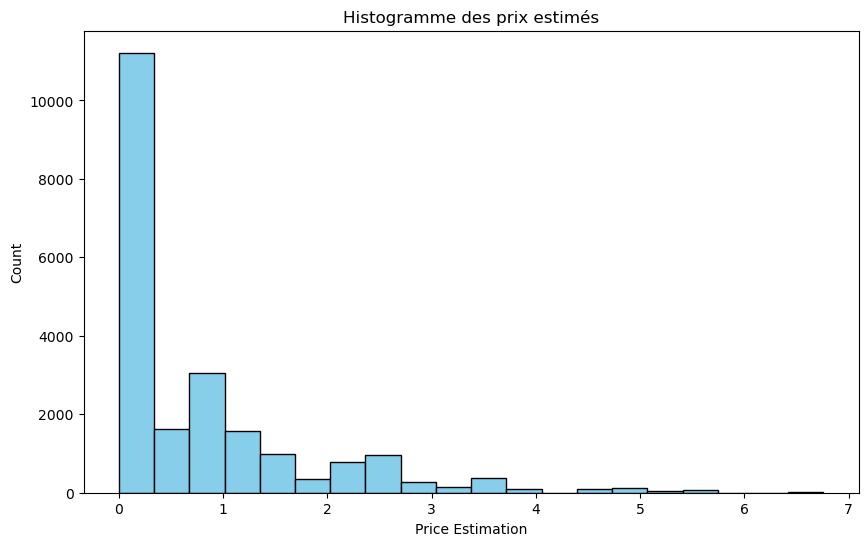

In [18]:
# Histogramme des prix estimés
plt.figure(figsize=(10, 6))
plt.hist(basket['Price estimation'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogramme des prix estimés')
plt.xlabel('Price Estimation')
plt.ylabel('Count')
plt.show()

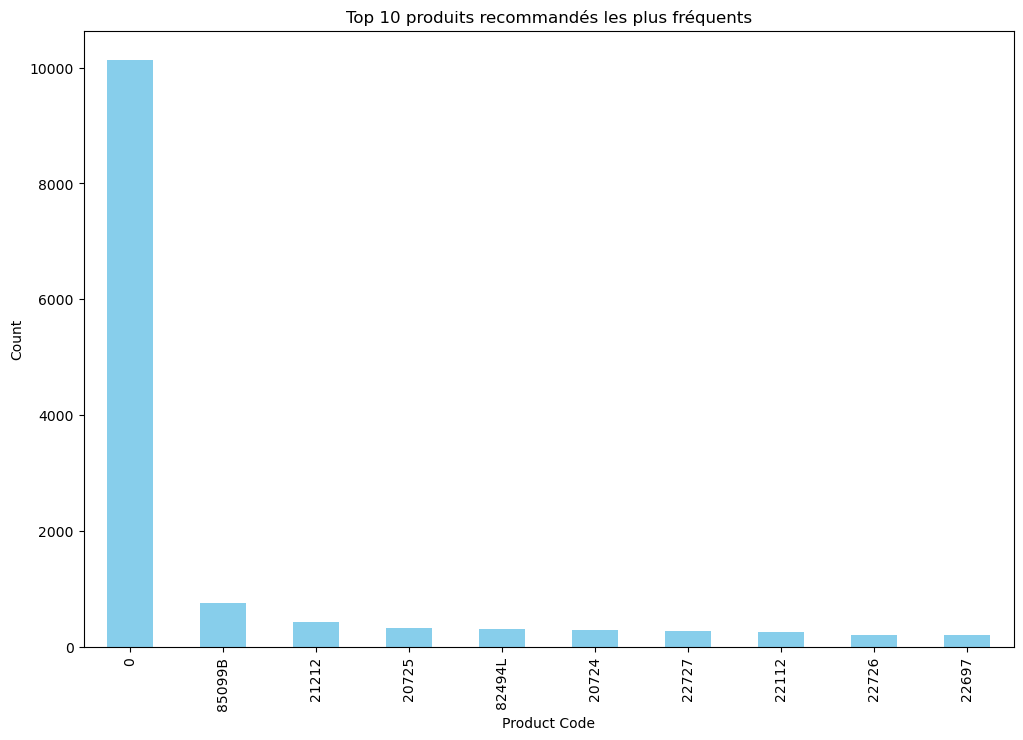

In [19]:
# Produits recommandés les plus fréquents
top_recommended_products = basket['Recommended Product'].value_counts().head(10)

# Graphique des produits recommandés les plus fréquents
plt.figure(figsize=(12, 8))
top_recommended_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 produits recommandés les plus fréquents')
plt.xlabel('Product Code')
plt.ylabel('Count')
plt.show()


In [20]:
# Filtrer les règles en fonction du support et de la confiance
min_support_threshold = 0.05
min_confidence_threshold = 0.7

Filtered Rules:
                  antecedent consequent  confidence
1                    {23285}    {23286}    0.872180
2                    {23291}    {23289}    0.809524
3                    {23289}    {23291}    0.820690
5                    {23289}    {23290}    0.820690
6                    {23255}    {23254}    0.753425
...                      ...        ...         ...
2700  {85099B, 20725, 23209}    {23203}    0.840491
2702         {85099B, 23209}    {23203}    0.789883
2703          {23203, 22383}    {23209}    0.751323
2711          {20727, 23203}    {23209}    0.742718
2713          {20725, 23203}    {23209}    0.766284

[1188 rows x 3 columns]


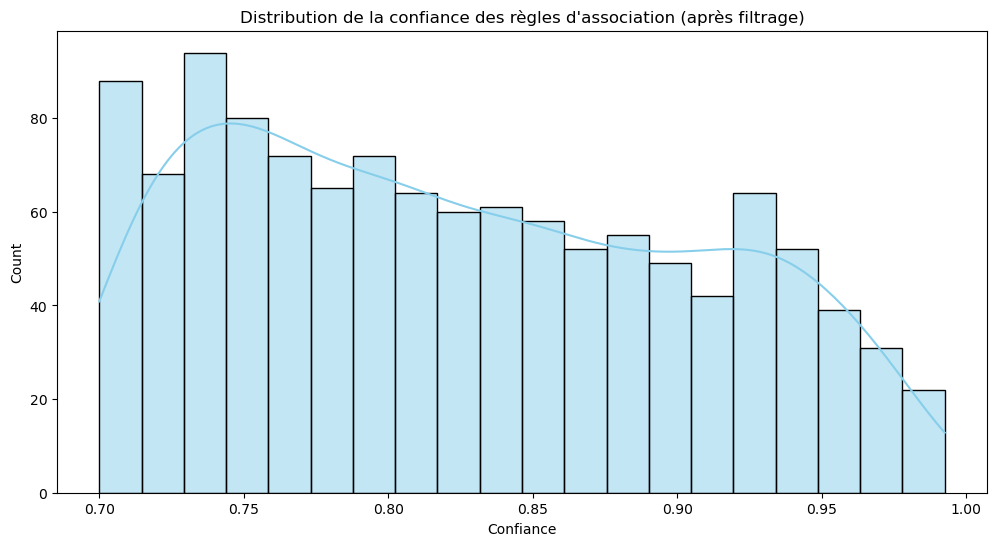

In [21]:
# Convertir les règles en DataFrame
rules_df = pd.DataFrame(rules, columns=['antecedent', 'consequent', 'confidence'])

# Filtrer les règles en fonction de la confiance
filtered_rules = rules_df[rules_df['confidence'] >= min_confidence_threshold]

# Visualisation des règles filtrées
print("Filtered Rules:")
print(filtered_rules)

# Visualisation de la confiance des règles d'association (après filtrage)
plt.figure(figsize=(12, 6))
sns.histplot(filtered_rules['confidence'], bins=20, kde=True, color='skyblue')
plt.title('Distribution de la confiance des règles d\'association (après filtrage)')
plt.xlabel('Confiance')
plt.ylabel('Count')
plt.show()
